<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/NCF/original_NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0 Import

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge
from keras.utils import plot_model
from IPython.display import SVG
import matplotlib.pyplot as plt
from keras.backend import reshape as Reshape

# 1 Data Load

In [102]:
dataset = pd.read_csv('/content/drive/My Drive/datasets/Movie_Dataset/ratings_small.csv', header=0)

In [103]:
dataset.head(1)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144


# 2 Preprocessing

### user

In [104]:
user_id = dataset['userId'].unique().tolist()
print(len(user_id))

671


In [105]:
user2i = {u:i for i,u in enumerate(user_id)}
i2user = {i:u for i,u in enumerate(user_id)}

In [106]:
num_users = len(user2i) # user명에서 i로 변환된것을 사용

dataset 내의 모든 user에게 id 부여

In [107]:
dataset['user'] = dataset['userId'].map(user2i) # new row 'user'
print(dataset['user'].head(2))

0    0
1    0
Name: user, dtype: int64


#### movie

In [108]:
movie_id = dataset['movieId'].unique().tolist()

In [109]:
movie2i = {m:i for i,m in enumerate(movie_id)}
i2movie = {i:m for i,m in enumerate(movie_id)}

In [110]:
num_movies = len(i2movie) # 인덱스에서 movie로 변환된 것을 사용할 것

In [111]:
dataset['movie'] = dataset['movieId'].map(movie2i)
print(dataset['movie'].head(2))

0    0
1    1
Name: movie, dtype: int64


#### ratings

In [112]:
dataset['rating'] = dataset['rating'].values
print(dataset['rating'])

0         2.5
1         3.0
2         3.0
3         2.0
4         4.0
         ... 
99999     2.5
100000    4.0
100001    4.0
100002    2.5
100003    3.5
Name: rating, Length: 100004, dtype: float64


# 2 Train/Val set 

- X_data = 예측에 사용되는 데이터셋. user, movie를 가지고 만든다  
- y_data = X_data를 가지고 수행한 것의 정답을 확인하기 위해 사용

In [113]:
X_data = dataset[['user','movie']]

In [114]:
y_data = dataset['rating']

In [115]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(80003, 2)
(20001, 2)
(80003,)
(20001,)


# Modeling

## 2.0 Values in the originals

- Batch size: [128,256,512,1024]
- Learning Rate: [0.0001,0.0005,0.001,0.005]
- CF Layer: 32 -> 16 -> 8
- Emb size: 16

##### Review tesor

In [116]:
import torch
import numpy as np
a = torch.Tensor(np.arange(8).reshape(2,4))
b = torch.Tensor(np.arange(8).reshape(2,4))
a = np.asarray(a).astype('float32')
b = np.asarray(b).astype('float32')

print(f'a: {a}\n')
print(f'b: {b}\n')
print(f'resize: {Reshape(a, shape=(1,8))}\n')
print(f'Dot: {keras.layers.Dot(axes=1)([a,b])}\n')
print(f'element-wise dot: {a*b}\n')
print(f'concat: {layers.Concatenate(axis=0)([a,b])}\n')

a: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

b: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

resize: [[0. 1. 2. 3. 4. 5. 6. 7.]]

Dot: [[ 14.]
 [126.]]

element-wise dot: [[ 0.  1.  4.  9.]
 [16. 25. 36. 49.]]

concat: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]
 [0. 1. 2. 3.]
 [4. 5. 6. 7.]]



## 2.1 GMF  
  
Generalized Matrix Factorizations  


모델링

In [117]:
Embedding_size = 16

class GMF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(GMF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed')
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)




    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        mat = user_vec * movie_vec
        x = mat + user_bias + movie_bias

        return x



test_model = GMF(num_users, num_movies, Embedding_size)
test_model.compile(loss = keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.Adam(lr=0.001), metrics=['RootMeanSquaredError'])

In [120]:
test_model.summary()

Model: "gmf_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embed (Embedding)       multiple                  10736     
_________________________________________________________________
embedding_62 (Embedding)     multiple                  671       
_________________________________________________________________
movie_embed (Embedding)      multiple                  145056    
_________________________________________________________________
embedding_63 (Embedding)     multiple                  9066      
Total params: 165,529
Trainable params: 165,529
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = test_model.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
626/626 [==============================] - 3s 4ms/step - loss: 3.3047 - root_mean_squared_error: 3.4743 - val_loss: 3.0610 - val_root_mean_squared_error: 3.2429
Epoch 2/10
626/626 [==============================] - 3s 4ms/step - loss: 2.7392 - root_mean_squared_error: 2.9441 - val_loss: 2.4252 - val_root_mean_squared_error: 2.6449
Epoch 3/10
626/626 [==============================] - 3s 4ms/step - loss: 2.0728 - root_mean_squared_error: 2.3223 - val_loss: 1.7903 - val_root_mean_squared_error: 2.0548
Epoch 4/10
626/626 [==============================] - 3s 4ms/step - loss: 1.5216 - root_mean_squared_error: 1.8019 - val_loss: 1.3714 - val_root_mean_squared_error: 1.6533
Epoch 5/10
626/626 [==============================] - 3s 4ms/step - loss: 1.2077 - root_mean_squared_error: 1.4848 - val_loss: 1.1559 - val_root_mean_squared_error: 1.4290
Epoch 6/10
626/626 [==============================] - 3s 4ms/step - loss: 1.0364 - root_mean_squared_error: 1.3015 - val_loss: 1.0316 - val_

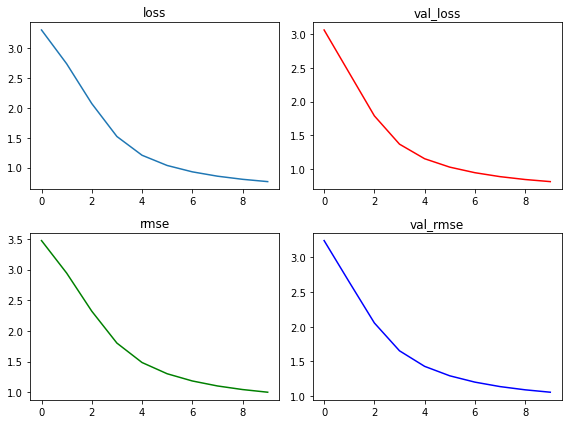

In [121]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

In [ ]:

        # GMF part

        self.user_embedding_gmf = Embedding(num_users, Embedding_size, name='user_emb_gmf')
        self.user_bias_gmf = Embedding(num_users,1)

        self.movie_embedding_gmf = Embedding(num_movies, Embedding_size, name='movie_emb_gmf')
        self.movie_bias_gmf = Embedding(num_movies,1)


## 2.2 MLP  
  
신경망을 이용한 파트

$\hat{y_{ui}} = \sigma(h^T a(p_u * q_u + W [p_{u_{1,1}}\  q_{u_{2,1}}] + b))$

In [175]:
Embedding_size = 16

class MLP(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(32,activation='elu')
        self.Layer2 = layers.Dense(16,activation='elu')
        self.Layer3 = layers.Dense(8,activation='elu')
        self.Layer4 = layers.Dense(1,activation='elu')
        self.dropout = layers.Dropout(0.5)

    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        #mat = user_vec * movie_vec
        mat = keras.layers.Concatenate()([user_vec, movie_vec])
        x = mat + user_bias + movie_bias

        x = self.dropout(self.Layer1(x))
        x = self.dropout(self.Layer2(x))
        x = self.dropout(self.Layer3(x))

        return self.Layer4(x)



test_model2 = MLP(num_users, num_movies, Embedding_size)
test_model2.compile(loss = keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.Nadam(lr=0.001), metrics=['RootMeanSquaredError'])

In [177]:
history2 = test_model2.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
626/626 [==============================] - 4s 7ms/step - loss: 1.0689 - root_mean_squared_error: 1.3278 - val_loss: 0.7916 - val_root_mean_squared_error: 0.9723
Epoch 2/10
626/626 [==============================] - 4s 7ms/step - loss: 0.9506 - root_mean_squared_error: 1.1893 - val_loss: 0.7317 - val_root_mean_squared_error: 0.9215
Epoch 3/10
626/626 [==============================] - 4s 7ms/step - loss: 0.8647 - root_mean_squared_error: 1.0880 - val_loss: 0.7108 - val_root_mean_squared_error: 0.9074
Epoch 4/10
626/626 [==============================] - 4s 7ms/step - loss: 0.7976 - root_mean_squared_error: 1.0105 - val_loss: 0.6991 - val_root_mean_squared_error: 0.9034
Epoch 5/10
626/626 [==============================] - 4s 7ms/step - loss: 0.7470 - root_mean_squared_error: 0.9558 - val_loss: 0.6961 - val_root_mean_squared_error: 0.8980
Epoch 6/10
626/626 [==============================] - 4s 7ms/step - loss: 0.7136 - root_mean_squared_error: 0.9211 - val_loss: 0.6886 - val_

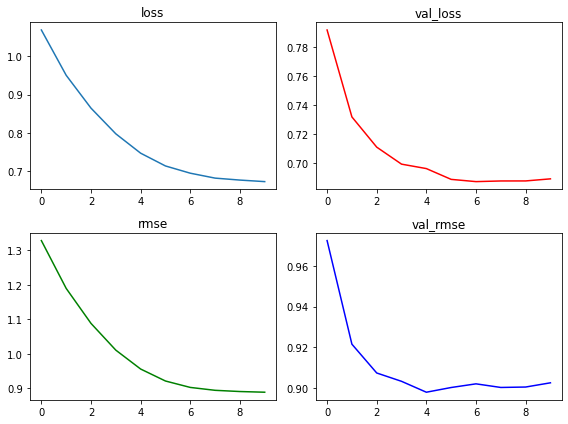

In [178]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history2.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history2.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history2.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history2.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## 2.3 Neu-MF  
  
Concatenate GMF and MLP parts

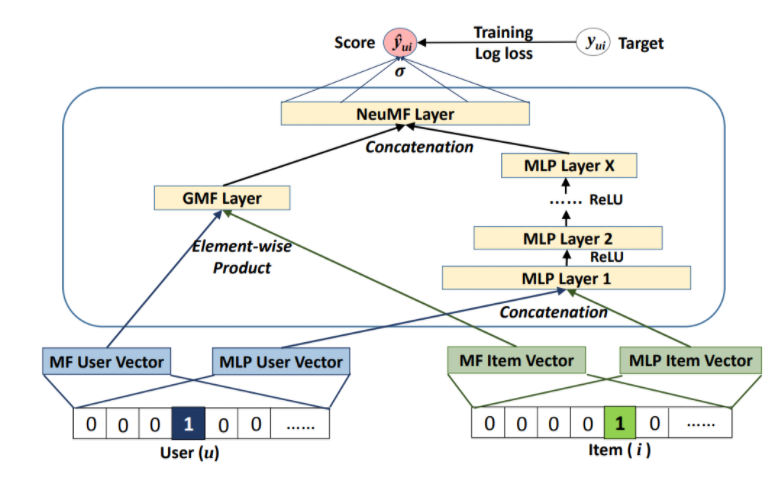

In [173]:
from IPython.display import Image
Image('/content/drive/My Drive/datasets/img/recommender/cnf.PNG')

In [181]:
Embedding_size = 16

class Neu_MF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Neu_MF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(32,activation='elu')
        self.Layer2 = layers.Dense(16,activation='elu')
        self.Layer3 = layers.Dense(8,activation='elu')
        self.Layer4 = layers.Dense(1,activation='elu')
        self.dropout = layers.Dropout(0.5)

    def call(self, inputs):
        
        # GMF

        user_vec_gmf = self.user_embedding(inputs[:,0])
        user_vec_gmf = Reshape(user_vec_gmf, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_gmf = self.user_bias(inputs[:,0])

        movie_vec_gmf = self.movie_embedding(inputs[:,1])
        movie_vec_gmf = Reshape(movie_vec_gmf, shape = (-1, self.embedding_size))
        movie_bias_gmf = self.movie_bias(inputs[:,1])

        mat_gmf = user_vec_gmf * movie_vec_gmf
        gmf = mat_gmf + user_bias_gmf + movie_bias_gmf

        # MLP

        user_vec_mlp = self.user_embedding(inputs[:,0])
        user_vec_mlp = Reshape(user_vec_mlp, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_mlp = self.user_bias(inputs[:,0])

        movie_vec_mlp = self.movie_embedding(inputs[:,1])
        movie_vec_mlp = Reshape(movie_vec_mlp, shape = (-1, self.embedding_size))
        movie_bias_mlp = self.movie_bias(inputs[:,1])

        # concat in MLP part

        concat_mlp = keras.layers.Concatenate()([user_vec_mlp, movie_vec_mlp])

        # MLP Layers
        x = self.dropout(self.Layer1(concat_mlp))
        x = self.dropout(self.Layer2(x))
        x = self.dropout(self.Layer3(x))
        mlp = x

        # concat MLP n GMF
        x = keras.layers.Concatenate()([gmf, mlp])

        # Final Prediction

        pred = self.Layer4(x)

        return pred

test_model3 = Neu_MF(num_users, num_movies, Embedding_size)
test_model3.compile(loss = keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.Nadam(lr=0.001), metrics=['RootMeanSquaredError'])

In [182]:
history3 = test_model3.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
626/626 [==============================] - 5s 8ms/step - loss: 1.3988 - root_mean_squared_error: 1.7753 - val_loss: 0.7761 - val_root_mean_squared_error: 0.9784
Epoch 2/10
626/626 [==============================] - 5s 7ms/step - loss: 0.8430 - root_mean_squared_error: 1.0710 - val_loss: 0.7313 - val_root_mean_squared_error: 0.9468
Epoch 3/10
626/626 [==============================] - 4s 7ms/step - loss: 0.7084 - root_mean_squared_error: 0.9236 - val_loss: 0.7099 - val_root_mean_squared_error: 0.9323
Epoch 4/10
626/626 [==============================] - 4s 7ms/step - loss: 0.6615 - root_mean_squared_error: 0.8759 - val_loss: 0.6993 - val_root_mean_squared_error: 0.9199
Epoch 5/10
626/626 [==============================] - 4s 7ms/step - loss: 0.6417 - root_mean_squared_error: 0.8573 - val_loss: 0.6950 - val_root_mean_squared_error: 0.9159
Epoch 6/10
626/626 [==============================] - 4s 7ms/step - loss: 0.6295 - root_mean_squared_error: 0.8479 - val_loss: 0.6947 - val_

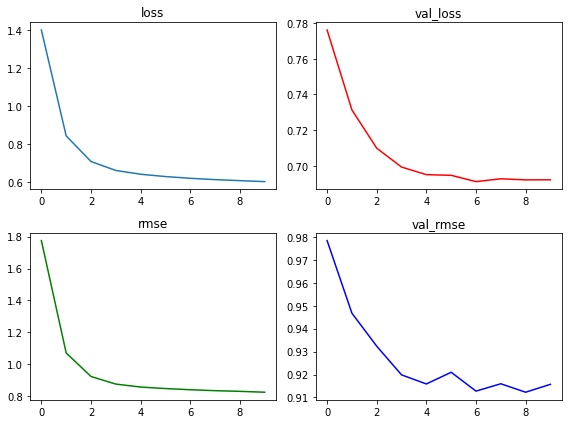

In [183]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history3.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history3.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history3.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history3.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()